In [8]:
# import libraries
import cv2
import mediapipe as mp
import numpy as np 
import matplotlib.pyplot as plt

# Import MediaPipe Drawing module
mp_drawing = mp.solutions.drawing_utils
# Import MediaPipe Pose module
mp_pose = mp.solutions.pose

In [2]:
# Define function to draw keypoints and connections
def draw_keypoints_and_connections(image, landmarks, mode):
    # Get image dimensions
    height, width, _ = image.shape
    # Initialize list to the landmarks pixel coordinates
    landmark_points = []
    for landmark in landmarks:
        landmark_point = (int(landmark.x * width), int(landmark.y * height))
        landmark_points.append(landmark_point)

    # Define connections for 'all' mode, excluding face and hand landmarks
    connections_all = []
    for conn in mp_pose.POSE_CONNECTIONS:
        exclude = False
        for lm in conn:
            if lm in range(0, 11) or lm in range(17, 23):
                exclude = True
                break
        if not exclude:
            connections_all.append(conn)

  
    # Define connections for 'right' mode
    connections_right = [
        (mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_HIP),
        (mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_KNEE),
        (mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_HEEL),
        (mp_pose.PoseLandmark.RIGHT_HEEL, mp_pose.PoseLandmark.RIGHT_FOOT_INDEX)
    ]
    # Define connections for 'left' mode
    connections_left = [
        (mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_HIP),
        (mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_KNEE),
        (mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_HEEL),
        (mp_pose.PoseLandmark.LEFT_HEEL, mp_pose.PoseLandmark.LEFT_FOOT_INDEX)
    ]

    # Determine which keypoints and connections to draw
    keypoints_to_draw = set()
    connections_to_draw = []

    # Add keypoints and connections to draw based on the mode
    if mode == 'all':
        for idx in range(11, 17):
            keypoints_to_draw.add(idx)
        for idx in range(23, 33):
            keypoints_to_draw.add(idx)
        connections_to_draw = connections_all

    elif mode == 'right':
        for connection in connections_right:
            keypoints_to_draw.add(connection[0])
            keypoints_to_draw.add(connection[1])
        connections_to_draw = connections_right

    elif mode == 'left':
        for connection in connections_left:
            keypoints_to_draw.add(connection[0])
            keypoints_to_draw.add(connection[1])
        connections_to_draw = connections_left

    # Draw the connections
    for connection in connections_to_draw:
        start_point = landmark_points[connection[0]]
        end_point = landmark_points[connection[1]]
        cv2.line(image, start_point, end_point, (245,117,66), 2)

    # Draw the keypoints
    for idx in keypoints_to_draw:
        point = landmark_points[idx]
        cv2.circle(image, point, 2, (245,66,230), thickness=-1)

In [12]:
# Function to compute angle
def calculate_angle(v1, v2, joint):
    
    dot_product = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle_radians = np.arccos(np.clip(dot_product, -1.0, 1.0))  # Clip for stability
    angle_degrees = np.degrees(angle_radians)

    cross_product = v1[0] * v2[1] - v1[1] * v2[0]
    
    if cross_product > 0:
       angle_direction = -1
    else:
        angle_direction = 1
    
    if joint == 'hip':
        angle_direction = -1 if v2[0]<0 else 1
    else:
        # angle_direction = 1 if cross_product > 0 else -1 
        angle_direction = 1
    
    angle = angle_direction*angle_degrees

    return angle

In [16]:
cap = cv2.VideoCapture('video_sample.avi')

hip_angle_over_time = []
knee_angle_over_time = []
# Define the codec and create VideoWriter object

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_video.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))


# Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5, static_image_mode=False, model_complexity=2) as pose:
    while cap.isOpened():
        
        ret, frame = cap.read()
        if ret:
            frame_height, frame_width, _ = frame.shape
        else:
            break
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
         # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            pass
    
        # Call the function to draw keypoints and connections
        draw_keypoints_and_connections(image, landmarks, 'right')  # Use 'right' or 'left' as needed
        
        right_shoulder = np.array([landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y])
        
        right_hip = np.rint(np.array([landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x * frame_width,
                                landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y * frame_height]))
        right_knee = np.rint(np.array([landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x * frame_width,
                                landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y * frame_height]))
        right_heel = np.rint(np.array([landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].x * frame_width,
                                landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].y * frame_height]))   

        
        # Define vector to compute knee and hip angle
        a = np.array([0,1])
        b = right_knee - right_hip
        c = right_knee -right_hip
        d = right_heel - right_knee

        # compute angles
        hip_angle = round(calculate_angle(a, b, 'hip'))
        knee_angle = round(calculate_angle(c, d, 'knee'))

        # append angle values to hip and angle over time lists
        hip_angle_over_time.append(hip_angle)
        knee_angle_over_time.append(knee_angle)

        
        # Display the angle at the hip position in yellow with a smaller font size
        cv2.putText(image, str(hip_angle), 
                    tuple(right_hip.astype(int)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image, str(knee_angle), 
                    tuple(right_knee.astype(int)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
        
        # write frame into the file 'output_video.avi'
        out.write(image)
        # Show the image
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

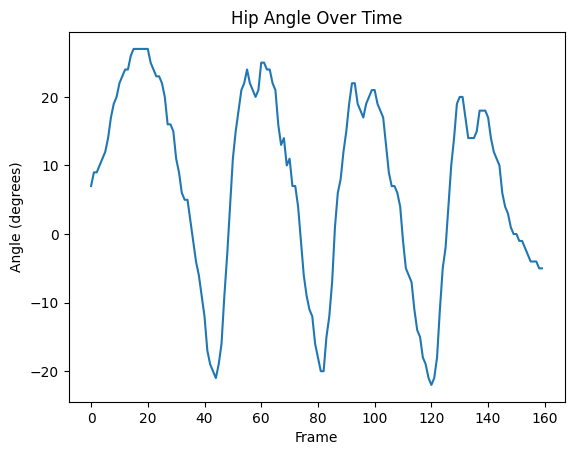

In [14]:
plt.figure()
plt.plot(hip_angle_over_time)
plt.title('Hip Angle Over Time')
plt.xlabel('Frame')
plt.ylabel('Angle (degrees)')
plt.show()

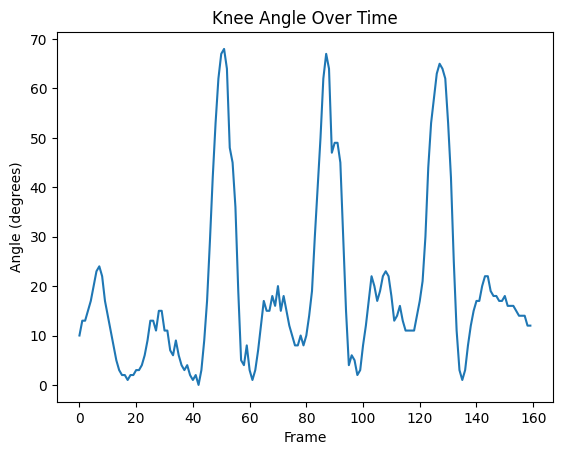

In [15]:
plt.figure()
plt.plot(knee_angle_over_time)
plt.title('Knee Angle Over Time')
plt.xlabel('Frame')
plt.ylabel('Angle (degrees)')
plt.show()